#### Ornstein-Uhlenbeck process without parameter estimation

The Ornstein-Uhlenbeck (OU) process is a continuous-time continuous-space
stochastic process governed by the stochastic differential equation (SDE)

          dY(t) = (Θ_1 - Θ_2 Y(t)) dt + Θ_3 dW(t)

where W(t) is the Wiener process (standard Brownian motion). This OU process is
stationary, Gaussian and Markovian. It is mean-reverting in the sense that it
drifts towards its long-term mean of Θ_1 / Θ_2.

For a step size Δt, the transition distribution can be obtained analytically as
a Normal with mean μ(Δt) and variance σ^2(Δt):

      Y(t + Δt) | Y(t) ~ Normal(μ(Δt), σ^2(Δt))
                 μ(Δt) = Θ_1 / Θ_2 + (Y(t) - Θ_1 / Θ_2) exp(- Θ_2 Δt)
               σ^2(Δt) = Θ_3^2 / (2 * Θ_2) * (1 - exp(- 2 Θ_2 Δt))

Given a sequence of noisy observations of the process Y(t_n) ≈ y_n for
1 <= n <= N, the task is to infer the posterior distribution over each Y(t_n).
This choice is for the sake of simplicity, the example can be modified to
infer posterior distributions over any Y(t).

This example has been inspired by the LibBi example at
http://libbi.org/packages/OrnsteinUhlenbeckBridge.html.

##### References:
- Y. Aït-Sahalia. Transition densities for interest rate and other nonlinear
  diffusions. The Journal of Finance, 54(4):1361–1395, 1999. ISSN 1540-6261.
  doi: 10.1111/0022-1082.00149.
- L. Sun, C. Lee, and J. A. Hoeting. Penalized importance sampling for parameter
  estimation in stochastic differential equations. 2013.
  URL http://arxiv.org/abs/1305.4390.
- Del Moral, Pierre, and Lawrence M. Murray. "Sequential Monte Carlo with highly
  informative observations." SIAM/ASA Journal on Uncertainty Quantification 3,
  no. 1 (2015): 969-997. http://arxiv.org/pdf/1405.4081v2.pdf
- C. E. Rasmussen and C. K. I. Williams. Gaussian Processes for Machine Learning
  (Adaptive Computation and Machine Learning). The MIT Press, 2005.
  ISBN 978-0-262-18253-9. URL http://www.gaussianprocess.org/gpml/.

True posterior of last state: Distributions.Normal(μ=0.04290846886466264, σ=0.009025242808127828)


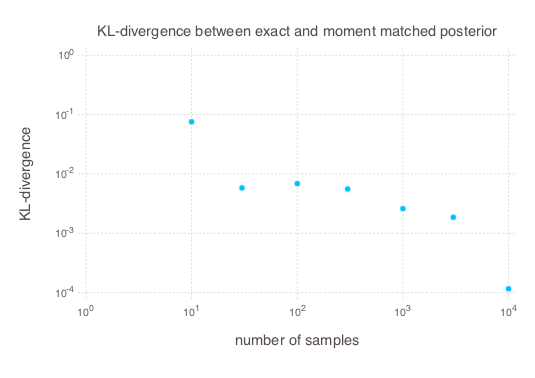

In [3]:
using Turing, Distributions

#= The parameter values of Θ_1, Θ_2, Θ_3 follow [Aït-Sahalia, 1999],
   [Sun et al., 2013] and [Del Moral et al., 2015]. =#
const Θ_1 = 0.0187
const Θ_2 = 0.2610
const Θ_3 = 0.0224

#= [Del Moral, 2015] observe the OU process directly with no observation noise,
and their task is to simulate the diffusion bridges between the observed values.
Our examples uses observation noise with standard deviation σ_y > 0, as this is
required for inference to work at this stage. =#
const σ_y = 0.01

#= The observation times ts and the corresponding observed values.
   It is assumed that the observation times are sorted increasingly. =#
ts      = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
data_ys = [0.0, -0.009114765844660457, 0.029830170268001097,
0.021755657377028295, 0.013934983652697013, 0.01910503829939146,
0.049404191951179434, 0.03253467537333853, 0.07701445971172535,
0.04618793002053633, 0.04001971135990065]
N = length(ts)

# The transition distribution of the OU process
function trans(Yt, Δt)
  mean = Θ_1 / Θ_2 + (Yt - Θ_1 / Θ_2) * exp(- Θ_2 * Δt)
  variance = Θ_3 * Θ_3 / (2 * Θ_2) * (1 - exp(- 2 * Θ_2 * Δt))
  # Normal is initialized with mean and standard deviation, not variance!
  return Normal(mean, sqrt(variance))
end

# The generative model of the OU process
@model ou begin
  # use TArray to support array copying when particles are duplicated!
  Y = TArray(Float64, N)
  Y[1] = 0.0
  for n = 2:N
    Δt = ts[n] - ts[n-1]
    @assume(Y[n] ~ trans(Y[n-1], Δt))
    @observe(data_ys[n] ~ Normal(Y[n], σ_y))
  end
  @predict Y
end


#= This concludes the example. The remainder of this script verifies that
inference works properly by checking that (potentially weighted) samples from
the posterior over Y[N] (the last element of the sequence Y) approximate the
exact posterior over Y[N].

The exact posterior over Y[N] is obtained by recalling that our OU process
is a Gaussian process [Rasmussen and Williams, 2005] with constant mean function
μ(t) = Θ_1 / Θ_2 and stationary covariance function

          k(r) = Θ_3^2 / (2 * Θ_2) * exp(- Θ_2 * |r|)

which is also known as the exponential, Laplace, or Laplacian kernel. (See
Appendix B.2.1 in [Rasmussen and Williams, 2005] for a derivation.) Hence exact
posteriors can be obtained by performing standard GP regression, which involves
inverting a kernel matrix A := (K + σ_y^2 I). =#

k(x, y) = Θ_3^2 / (2 * Θ_2) * exp(- Θ_2 * abs(x - y))
K = [k(x1, x2)::Float64 for x1=ts, x2=ts]
noise_matrix = σ_y^2 * eye(N)
noise_matrix[1, 1] = 0.0 # observed 0.0 at time t=0 with no noise
A = K + noise_matrix
Ainv = inv(A)

# Compute true posterior over Y[N], the value of Y(t) at time t=ts[N]
x_star = ts[N]
k_star = [k(x, x_star)::Float64 for x=ts]
f_star_mean = transpose(k_star) * (A \ (data_ys - Θ_1 / Θ_2)) + Θ_1 / Θ_2
f_star_variance = k(x_star, x_star) - transpose(k_star) * (A \ k_star)
f_star_std = sqrt(f_star_variance)
f_star_posterior = Normal(f_star_mean[1], f_star_std[1])
println("True posterior of last state: ", f_star_posterior)

# KL-divergence between a Normal MLE-fitted to samples and true posterior
function ou_divergence(samples, weights)
  fitted = fit_mle(Normal, samples, weights)
  return Turing.kl(fitted, f_star_posterior)
end
function ou_divergence(samples :: Vector{Float64})
  weights = fill(Float64(1), length(samples))
  return ou_divergence(samples, weights)
end

#= Compute the KL-divergence between moment-matched Normal from samples and
exact posterior, as the number of samples increases =#
num_samples = [10, 30, 100, 300, 1000, 3000, 10000]
samples = sample(ou, SMC(maximum(num_samples)))
samples_lasty = [res[N]::Float64 for res=samples[:Y]]
kl_divergences = map(n -> ou_divergence(samples_lasty[1:n]), num_samples)

# Plot the results using Gadfly
using Gadfly
plot(x=num_samples, y=kl_divergences,
     Scale.x_log10, Scale.y_log10,
     Guide.title("KL-divergence between exact and moment matched posterior"),
     Guide.xlabel("number of samples"), Guide.ylabel("KL-divergence"))